# Integrated Gradients

The integrated gradients attribution method produces an image-specific attribution map. This method is an adaptation of the "gradients $\times$ input" method. Its slower than "gradients $\times$ input" since it needs to calculate gradients for the input at many different scales, but provides better accuracy. It can be used with any classification model, since it only depends on the inputs gradients, not any gradients from the hidden layers.

For more technical information on the integrated gradients attribution method see: [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import flax
import flax.linen as nn
import jax
from jax import random
from jax import vmap
from jax import grad
from keras.utils import data_utils

2022-11-21 10:38:40.958987: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 10:38:42.964852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-21 10:38:42.965517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-21 10:38:42.965532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned a

### Load training data
Check if the training data exists. If not, automatically download it.

In [2]:
data_dir = os.path.abspath("./digit-recognizer")
os.makedirs(data_dir, exist_ok=True)
train_data_path = f"{data_dir}/train.zip"
train_data_url = "https://huggingface.co/datasets/ChristianOrr/mnist/resolve/main/train.zip"

if not os.path.exists(train_data_path):
    print("Downloading training data...")
    data_utils.get_file(
        train_data_path, 
        train_data_url, 
        extract=True, 
        cache_dir=data_dir
        )

data_df = pd.read_csv('./digit-recognizer/datasets/train.csv')

In [3]:
val_size = 1000
# Only shuffle training data
np.random.shuffle(data_df[val_size:].values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[val_size:]
X_train = X_train / 255.
Y_train = Y[val_size:]

X_val = X[:val_size]
X_val = X_val / 255.
Y_val = Y[:val_size]

### Define the classification model

In [4]:
class _forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        mlp = nn.Sequential([
            nn.Dense(10), jax.nn.relu,
            nn.Dense(10), jax.nn.softmax        
        ])
        return mlp(x)

# Create the model object
forward_fn = _forward_fn()
# Display the model details
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)
initial_params = forward_fn.init(rng_key, dummy_x)
print(forward_fn.tabulate(rng_key, dummy_x))


                              _forward_fn Summary                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path         ┃ module      ┃ inputs         ┃ outputs       ┃ params         ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│              │ _forward_fn │ float32[5,784] │ float32[5,10] │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Sequential_0 │ Sequential  │ float32[5,784] │ float32[5,10] │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Dense_0      │ Dense       │ float32[5,784] │ float32[5,10] │ bias:          │
│              │             │                │               │ float32[10]    │
│              │             │                │               │ kernel:        │
│              │             │                │               │ float32[784,1… │
│              │           

### Define the loss function and update method

In [5]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[..., None] == jnp.arange(k), dtype)

def loss_fn(params, X, Y):
    logits = forward_fn.apply(params, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(logits)) / m
    return loss


def update_rule(params, update):
    return params - 0.1 * update

def update_params(params, alpha, X, Y):
    grads = grad(loss_fn, argnums=0)(params, X, Y)
    params = jax.tree_util.tree_map(update_rule, params, grads)
    return params


### Train the model

In [6]:
def get_predictions(logits):
    return jnp.argmax(logits, axis=1)

def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, alpha, iterations):
    rng = jax.random.PRNGKey(42)
    params = forward_fn.init(rng, X)
    for i in range(iterations):
        params = update_params(params, alpha, X, Y)
        if i % 10 == 0:
            print("Iteration: ", i)
            logits = forward_fn.apply(params, X)
            predictions = get_predictions(logits)
            print(get_accuracy(predictions, Y))
    return params

In [7]:
params = gradient_descent(X_train, Y_train, 0, 500)

Iteration:  0
0.103780486
Iteration:  10
0.36390242
Iteration:  20
0.4557073
Iteration:  30
0.5249024
Iteration:  40
0.5534634
Iteration:  50
0.59141463
Iteration:  60
0.6319024
Iteration:  70
0.6621707
Iteration:  80
0.68326825
Iteration:  90
0.70226824
Iteration:  100
0.71763414
Iteration:  110
0.73234147
Iteration:  120
0.74560976
Iteration:  130
0.7611951
Iteration:  140
0.7747561
Iteration:  150
0.7866829
Iteration:  160
0.795439
Iteration:  170
0.80202436
Iteration:  180
0.80826825
Iteration:  190
0.8137073
Iteration:  200
0.8189268
Iteration:  210
0.82275605
Iteration:  220
0.8270488
Iteration:  230
0.83131707
Iteration:  240
0.8344878
Iteration:  250
0.83763415
Iteration:  260
0.84109753
Iteration:  270
0.8441463
Iteration:  280
0.8468536
Iteration:  290
0.8494146
Iteration:  300
0.851439
Iteration:  310
0.85360974
Iteration:  320
0.8555366
Iteration:  330
0.858
Iteration:  340
0.8599512
Iteration:  350
0.86229265
Iteration:  360
0.86417073
Iteration:  370
0.86612195
Iteration:

### Create Integrated Gradients Function

The integrated gradients function creates a baseline input with the same dimensions as the original input, and default values set to 0. Then a batch of scaled inputs are created by linearly increasing the values of the (input - baseline). The gradients are calculated for each scaled input image. Then the integral of the gradients are calculated using the trapezoidal rule (for trapezoid rule explanation see [Understanding the trapezoidal rule](https://www.khanacademy.org/math/ap-calculus-ab/ab-integration-new/ab-6-2/a/understanding-the-trapezoid-rule)). The integral is then multiplied by the (input - baseline) to provide the intrated gradients. The integraed gradient for the i'th pixel is provided below:

$$IntegratedGrads_i(x) = (x_i - x'_i) \times \int_{\alpha = 0}^1 \frac{\partial F(x' + \alpha \times (x - x'))}{\partial x_i}   $$
, where $i$ is the pixels index, $x$ is the input, $x'$ is the basesline, $\alpha$ is the step size, $F$ is the classification neural network, and $\frac{\partial F(x)}{\partial x_i}$ is the gradient of $F$ for the i'th pixel.

In the function below the following variables are equal to the corresponding mathematical symbols:
 - inp = $x$
 - baseline = $x'$, 
 - grads_integral = $\int_{\alpha = 0}^1 \frac{\partial F(x' + \alpha \times (x - x'))}{\partial x}$

The integrated gradients function below was adapted from [ankurtaly/Integrated-Gradients](https://github.com/ankurtaly/Integrated-Gradients).

In [8]:
def integrated_gradients(
    inp, 
    target_label_index,
    batched_grad,
    baseline=None,
    steps=50):
    """Computes integrated gradients for a given network and prediction label.

    Integrated gradients is a technique for attributing a deep network's
    prediction to its input features. It was introduced by:
    https://arxiv.org/abs/1703.01365

    This method only applies to classification networks, i.e., networks 
    that predict a probability distribution across two or more class labels.

    Access to the specific network is provided to the method via a
    'batched_grad' function provided as argument to this method.
    The function takes the network params, a batch of inputs and a label, 
    and returns the gradients of the prediction with respect to the input. 

    Args:
        inp: The specific input for which integrated gradients must be computed.
        target_label_index: Index of the target class for which integrated gradients
            must be computed.
        batched_grad: This function provides access to the
            network's gradients. It takes the following arguments:
                - params: The networks weights.
                - inputs: A batch of tensors of the same shape as 'inp'. The first
                    dimension is the batch dimension, and rest of the dimensions coincide
                    with that of 'inp'.
                - target_label_index: The index of the target class for which gradients
                    must be obtained.
                and returns:
                - gradients: Batched gradients of the prediction for the target class 
                    (denoted by target_label_index) with respect to the inputs. 
                    The batches have the same shape as 'inputs'.
        baseline: [optional] The baseline input used in the integrated
            gradients computation. If None (default), the all zero tensor with
            the same shape as the input (i.e., 0*input) is used as the baseline.
            The provided baseline and input must have the same shape. 
        steps: [optional] Number of intepolation steps between the baseline
            and the input used in the integrated gradients computation. These
            steps along determine the integral approximation error. By default,
            steps is set to 50.

    Returns:
        integrated_gradients: The integrated_gradients of the prediction for the
        provided prediction label to the input. It has the same shape as that of
        the input.
    """    
    if baseline is None:
        baseline = 0*inp
    assert(baseline.shape == inp.shape)

    # Scale input and compute gradients.
    scaled_inputs = jnp.array([baseline + (float(i)/steps)*(inp-baseline) for i in range(0, steps+1)])
    grads = batched_grad(params, scaled_inputs, target_label_index) # shapes: <steps+1>, <steps+1, inp.shape>
    
    # Use trapezoidal rule to approximate the integral.
    # See Section 4 of the following paper for an accuracy comparison between
    # left, right, and trapezoidal IG approximations:
    # "Computing Linear Restrictions of Neural Networks", Matthew Sotoudeh, Aditya V. Thakur
    # https://arxiv.org/abs/1908.06214
    # Calculate the areas of the trapezoids
    trap_areas = (grads[:-1] + grads[1:]) / 2.0
    # Averaging the trapezoids provides the integral of the gradients
    grads_integral = jnp.average(trap_areas, axis=0)
    integrated_gradients = (inp-baseline) * grads_integral 
    return integrated_gradients
    

### Display predictions and attribution maps

The integrated gradients function needs a batched gradient function to provide gradients for a batch of images. The batched_grad function is created using vmap, then passed through to integrated_gradients. The attributions are then obtained and prepared for displaying. 

In [9]:
def make_predictions(X, params):
    logits = forward_fn.apply(params, X)
    predictions = get_predictions(logits)
    return predictions

def prep_image(image):
    # Normalize the gradient values to be between 0-1
    max_val= np.max(image)
    min_val = np.min(image)
    image = (image - min_val) / (max_val - min_val)
    # Convert the grads to uint8 for displaying
    image = np.uint8(image * 255)
    return image  

def display_prediction(index, params):
    current_image = X_val[None, index]
    prediction = make_predictions(X_val[None, index], params)
    label = Y_val[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    display_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(display_image, interpolation='nearest')
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    batched_grad = vmap(grad(loss_fn, argnums=1), in_axes=(None, 0, None))

    attributions = integrated_gradients(
        current_image[0],
        label,
        batched_grad,
        steps=50)

    attributions = attributions.reshape((28, 28))
    attributions = prep_image(attributions)
    plt.gray()
    plt.imshow(attributions, interpolation='nearest')
    plt.axis('off')
    plt.title("Attribution Map")
    plt.show()

Prediction:  [1]
Label:  1


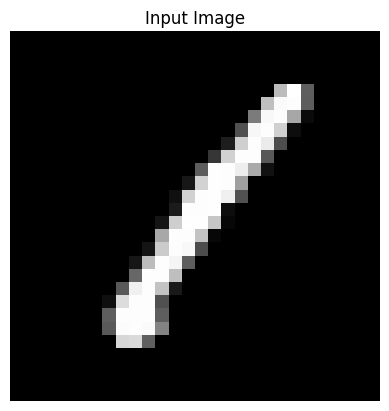

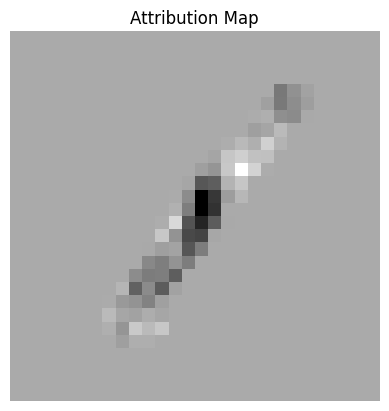

Prediction:  [6]
Label:  4


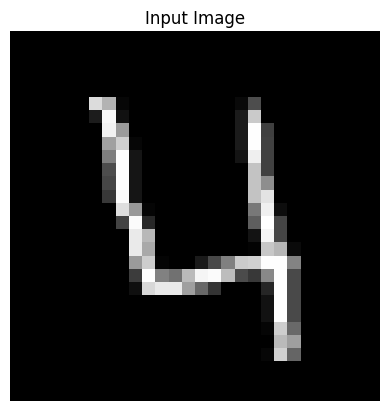

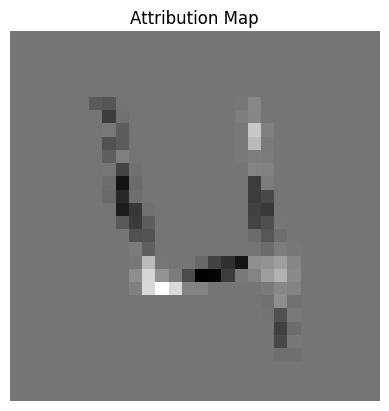

Prediction:  [3]
Label:  0


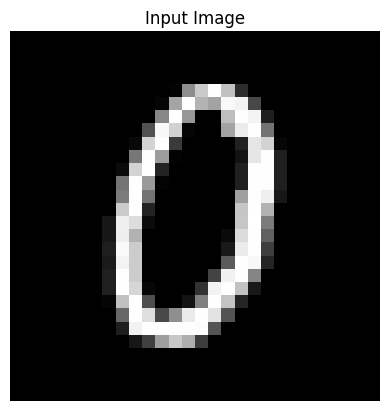

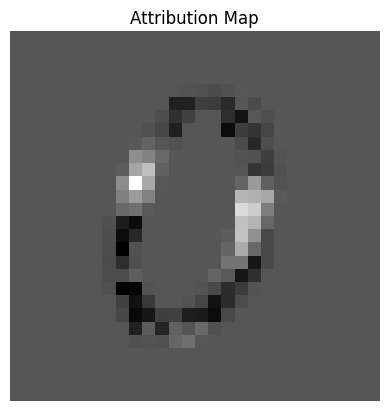

Prediction:  [5]
Label:  5


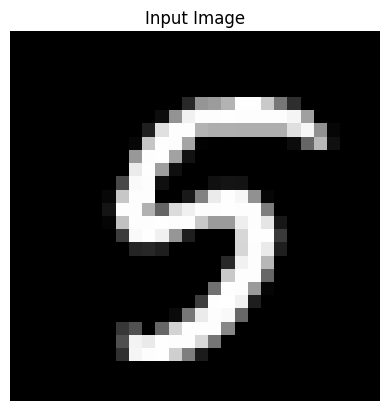

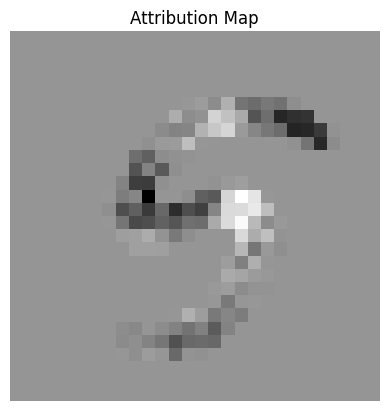

Prediction:  [8]
Label:  8


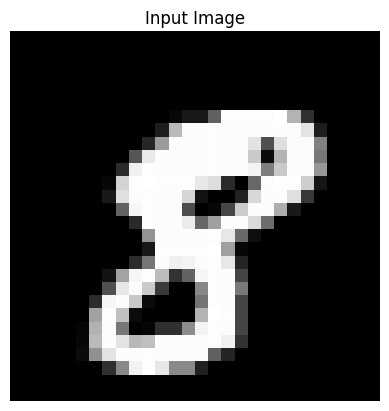

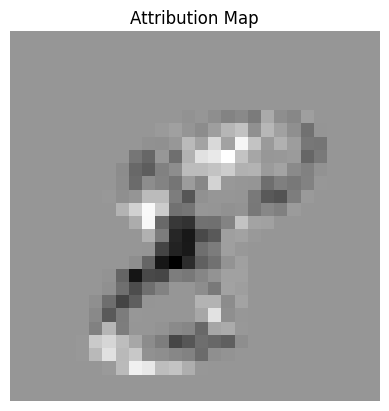

Prediction:  [7]
Label:  7


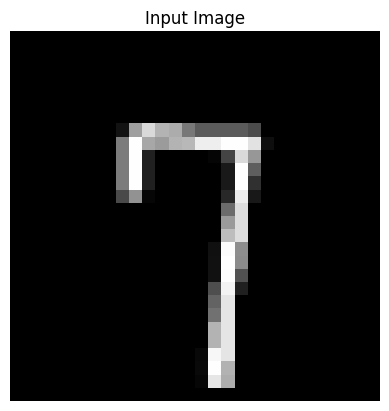

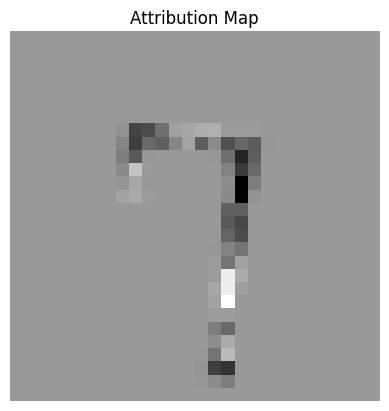

In [10]:
display_prediction(0, params)
display_prediction(3, params)
display_prediction(5, params)
display_prediction(8, params)
display_prediction(10, params)
display_prediction(50, params)